In [1]:
import numpy as np
import qiskit
import mitiq
import matplotlib.pyplot as plt
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error
from qiskit import *
from qiskit import IBMQ

In [2]:
#Define the functions used to build the Trotter circuit.
def h_Z(qc,h,dt):
    for i in range(5):
        if i==0 or i==4:
            qc.rz(h*dt,i)
        else:
            qc.rz(2*h*dt,i)
        
def X_Rabi(qc,Omega,dt): # Rabi coupling
    
    for i in range(5):
        
        qc.rx(2*Omega*dt,i)
        
def ZZ(qc,V,dt): # nearest neighbor coupling
    
    qc.cx(0,1)
    
    qc.rz(-2*V*dt,1)
    
    qc.cx(0,1)
    
    qc.cx(2,3)
    
    qc.rz(-2*V*dt,3)
    
    qc.cx(2,3)
    
    qc.cx(1,2)
    
    qc.rz(-2*V*dt,2)
    
    qc.cx(1,2)
    
    qc.cx(3,4)
    
    qc.rz(-2*V*dt,4)
    
    qc.cx(3,4)

def Trotter_circuit_5_site(h,Omega,V,T,n):
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(5)
        
        ### Initial state setting
        
        Trotter_circuit.x(1)
        
        Trotter_circuit.x(3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            X_Rabi(Trotter_circuit,Omega,dt) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt) # Z field 
            
            ZZ(Trotter_circuit,V,dt) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        Trotter_circuit.measure_all()
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

In [3]:
#Parameters used for the Trotter cirucit
Omega = 0.2*2

h = 2*2

V = 1*2

T = 10 # Total time

TT=T

#NEED TO CHECK IF THIS IS ALLOWED
delta_t = .5

#CHECK THIS AS WELL
n = int(np.rint(T/delta_t))

NN=n

Trotter_circuit = Trotter_circuit_5_site(h,Omega,V,T,n)

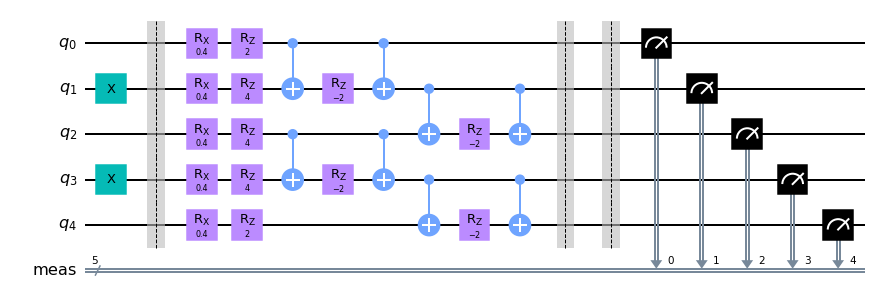

In [43]:
Trotter_circuit[1].draw('mpl')

In [44]:
backend = qiskit.Aer.get_backend("qasm_simulator")
# backend = FakeVigo()

job = qiskit.execute(Trotter_circuit[1],backend,shots=8192)
results = job.result()
counts = results.get_counts()

In [45]:
def post_selection(bit_str):
    """This function takes in a bitstring, and will return True iff 
    there is a 1 next to another 1 in the given bitstring.
    This does NOT consider a bitstring with 1s on either end as next to one another,
    i.e. given a string of the form '10...01', this function should return False"""
    new_str = '0' + bit_str[0:len(bit_str)]
    for i in range(0,len(bit_str)+1):
        if (new_str[i] == '1') & (new_str[i] == new_str[i-1]):
            return True
    return False

In [46]:
qubit = 0

copy_counts = counts.copy()

total = []

for x in counts.keys():
    if post_selection(x):
        copy_counts.pop(x)

for x in copy_counts:
    total.append(copy_counts[x])

total = sum(total)

one_counts = 0

for x in copy_counts.keys():
    if x[qubit] == '1':
        one_counts += copy_counts[x]

prob = one_counts / total

expval = 2*prob - 1

print(copy_counts)
        
print(one_counts)
print(total)
print(one_counts / total)
print(expval)

{'01010': 6628, '00010': 297, '01000': 249, '10010': 15, '00000': 10, '10000': 1, '01001': 10, '00100': 1}
16
7211
0.002218832339481348
-0.9955623353210373


In [47]:
def Z(bitstring, bit):
    if bitstring[bit] == '1':
        return -1
    else:
        return 1
    
def ZZ_measurement(bitstring, bit1, bit2):
    return Z(bitstring, bit1) * Z(bitstring, bit2)

def post_selected_expval(counts, qubit):
    copy_counts = counts.copy()
    
    total = []

    for x in counts.keys():
        if post_selection(x):
            copy_counts.pop(x)

    for x in copy_counts:
        total.append(copy_counts[x])

    total = sum(total)

    one_counts = 0

    for x in copy_counts.keys():
        if x[qubit] == '1':
            one_counts += copy_counts[x]

    prob = one_counts / total

    expval = 2*prob - 1
    
    return expval

In [48]:
expval_list = []

for x in copy_counts.keys():
    expval_list.append(ZZ_measurement(x,0,1) * copy_counts[x]/total)
    
print(sum(expval_list))

-0.9145749549299682


In [49]:
def ZZ_meas_expval(counts, bit1, bit2):
    copy_counts = counts.copy()
    total = []

    for x in counts.keys():
        if post_selection(x):
            copy_counts.pop(x)
    
    for x in copy_counts:
        total.append(copy_counts[x])
    
    total = sum(total)

    one_counts = 0

    for x in copy_counts.keys():
        if x[qubit] == '1':
            one_counts += copy_counts[x]

    prob = one_counts / total
    
    expval_list = []
    
    for x in copy_counts.keys():
        expval_list.append(ZZ_measurement(x,bit1,bit2) * copy_counts[x]/total)
    
    return sum(expval_list)

In [50]:
print(ZZ_meas_expval(counts, 0, 1))

-0.9145749549299682


In [51]:
test_thing = []

for x in range(0,5-1):
    test_thing.append((1 + post_selected_expval(counts,x) + post_selected_expval(counts,x+1) + 
           ZZ_meas_expval(counts,x,x+1))/4)

test_thing = sum(test_thing)

print(test_thing)

-5.551115123125783e-17
